<a href="https://colab.research.google.com/github/michalpiasecki0/2021L-WB-DL-2/blob/main/PD4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MORE METRICS!

**Praca domowa 4** \\
Michał Piasecki

In this work, I would like to analyse sensitivity of particular neural network.
Throughout this work, I will use architecture that I implemented in previous  
Let's start from a definition of 
**Sensitivity analysis of neural networks**

**Sensitivity analysis of neural networks** is a term, which describe how sensitive is particular neural network architecture for small distortions in data evaluated by a model or small changes in model parameters
We can change "environment" of model in three ways, after our model is trained we can:
1. Slightly change data, which model has to evaluate
2. Sligthly change parameters
3. Both change data and parameters

[Sensitivity Analysis of Deep Neural Networks Hai Shu, Hongtu Zhu 2019](https://arxiv.org/pdf/1901.07152.pdf)


As a reminder, our model works on CIFAR-10 data, which is set of labeled images divided into 10 categories. Here we will do the same thing like in previous notebook, mainly loading dataset, displaying examples in each category, build and train our model

## Packages

In [49]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(2020) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from numpy.random import seed
import copy
import skimage
from skimage.util import random_noise
from sklearn.metrics import classification_report



seed(12)


In [2]:
## Additional functions

In [3]:
def plotting_model(model_info):
  table = pd.DataFrame.from_dict(model_info.history)
  table.reset_index(inplace = True)
  plt.figure(figsize = (20,10))
  plt.plot(table['index'],table['accuracy'], color = 'skyblue', label = 'accuracy')
  plt.plot(table['index'],table['val_accuracy'], color = 'orange', label = 'test accuracy')
  plt.grid(alpha = 0.2)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(prop={'size': 20})
  plt.show()


def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)


## Loading Data

In [4]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test  =  test_features.shape[0]
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


## Displaying examples in each category

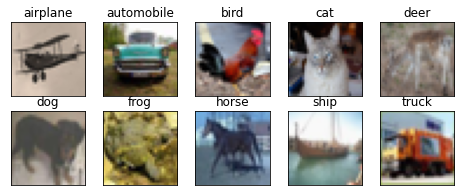

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Preprocessing

In [6]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Building model

In [8]:
model_basic = Sequential()
model_basic.add(Convolution2D(48, (3, 3),activation='relu', input_shape=(32, 32,3)))
model_basic.add(MaxPooling2D((2, 2)))
model_basic.add(Dropout(0.25))
model_basic.add(Convolution2D(96, (3, 3),activation='relu'))
model_basic.add(MaxPooling2D((2, 2)))
model_basic.add(Dropout(0.25))
model_basic.add(Convolution2D(192, (3, 3),activation='relu'))
model_basic.add(MaxPooling2D((2, 2)))
model_basic.add(Dropout(0.25))
model_basic.add(Flatten())
model_basic.add(Dense(512, activation = 'relu'))
model_basic.add(Dropout(0.5))
model_basic.add(Dense(256,activation = 'relu'))
model_basic.add(Dropout(0.5))
model_basic.add(Dense(num_classes, activation='softmax'))
model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Training model

In [9]:
model_basic.fit(x = train_features, y = train_labels, validation_split= 0.1, batch_size = 64, steps_per_epoch= 100, epochs= 200, verbose = 0)

In [52]:
results = model_basic.predict(test_features)
results
##classification_report(test_labels, results)

array([[2.0948222e-03, 1.6533491e-03, 1.5684120e-02, ..., 6.8481397e-03,
        6.8095047e-03, 2.0811434e-03],
       [3.7272086e-03, 1.9626518e-01, 5.0559095e-07, ..., 4.8057158e-09,
        7.9986620e-01, 1.4077207e-04],
       [7.1549669e-02, 1.8546692e-03, 6.3026194e-03, ..., 3.7529037e-04,
        9.1653663e-01, 3.4195435e-04],
       ...,
       [5.7393959e-07, 1.9521726e-09, 1.4856838e-02, ..., 3.4448633e-03,
        6.9425006e-08, 8.3078817e-08],
       [1.0200020e-02, 2.1143802e-01, 1.7550109e-02, ..., 2.4272418e-03,
        1.8947480e-03, 3.0195776e-03],
       [9.6840860e-12, 4.6689625e-15, 9.5934894e-08, ..., 9.9988306e-01,
        6.6272811e-15, 5.3649942e-14]], dtype=float32)

# Changing data
## Adding Gaussian Noise to data

As a first experiment, we will change our test data, adding a white noise (Gaussian noise) to every picture. We will add four different layers of noise, which will differ from value of variance of gaussian noise. With every layer we will see if there are any differences for human vision on 3 examples and then see how our model works on changed data

In [86]:

def add_gaussian_noise(images, variance_parameter):
  new_images = copy.deepcopy(images)
  for i in range(images.shape[0]):
    new_images[i,::] = random_noise(image = new_images[i,::], mode= 'gaussian', seed = 20, var = variance_parameter)    
  return new_images 
def show_few_examples(new_images_1, new_images_2, new_images_3, images):
  for i in range(2):
    image_index = np.random.randint(low = 0, high = new_images_1.shape[0])
    plt.figure(figsize=(2,2))
    plt.title("Normal picture")
    plt.imshow(test_features[image_index,::])
    plt.figure(figsize=(2,2))
    plt.title(f"+ Gaussian Noise 0.001")
    plt.imshow(new_images_1[image_index,::])
    plt.figure(figsize=(2,2))
    plt.title(f"+ Gaussian Noise 0.005")
    plt.imshow(new_images_2[image_index,::])
    plt.figure(figsize=(2,2))
    plt.title(f"+ Gaussian Noise 0.01")
    plt.imshow(new_images_3[image_index,::])
     
    
 

In [41]:
images_after_gaussian_noise = [add_gaussian_noise(test_features, 0.001), add_gaussian_noise(test_features,0.005), add_gaussian_noise(test_features,0.01)]


## Gaussian noise - examples

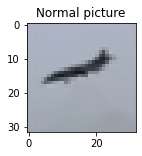

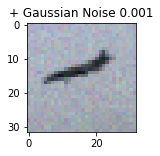

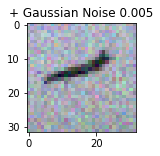

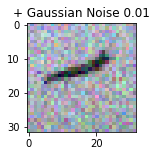

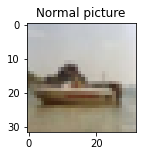

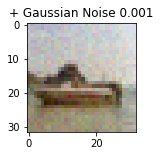

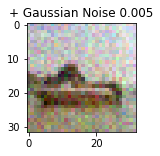

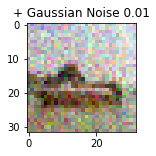

In [87]:
show_few_examples(images_after_gaussian_noise[0],images_after_gaussian_noise[1],images_after_gaussian_noise[2],test_features)

We can see that with Gaussian Noise with variance 0.001 there is barely any difference between normal photo and changed one (at least I am not able to spot it). When it comes to higher variances the differences start to be noticeable.
Let's see how our model work on them

In [70]:
values = [0.001, 0.005, 0.01]
print("Without noise")
print(accuracy(test_features,test_labels, model_basic))
for i in range(len(images_after_gaussian_noise)):
  print("Gaussian noise " + str(values[i]))
  print(accuracy(images_after_gaussian_noise[i], test_labels, model_basic))

Without noise
76.82
Gaussian noise 0.001
73.94
Gaussian noise 0.005
54.790000000000006
Gaussian noise 0.01
40.21


we can see that there is not much difference if we add very small noise (variance 0.001). Nevertheless, when we start to distort our images to higher extent our model starts to work poorely.

## Changing random 20 pixels
Now, we will change randomly n pixels in our images and see how our model will cope with this. I will add to every chosen pixel 1. We will se how many pixels needs to be changed to result in accuracy smaller than 50 %. Iteration step will be 5 pixels

In [84]:
def perturbation_in_images(images, n_pixels):
    ## choosing n pixels
    new_images = copy.deepcopy(images)
    counter = 0
    for image in images:
      new_image = copy.deepcopy(image)
      for k in range(n_pixels):
          i = np.random.randint(0,32)
          j = np.random.randint(0,32)
          s = np.random.randint(0,3)
          new_image[i,j,s] = image[i,j,s] + np.random.randint(low = 1, high = 2)
      new_images[counter, ::] = new_image
      counter = counter + 1
    return new_images
def how_many_pixels(images):
  actual_accuracy= accuracy(test_features, test_labels, model_basic)
  n_pixels = 0
  while(actual_accuracy > 50):
      print(f"Pictures with {n_pixels} pixels changed")
      print("Accuracy " + str(actual_accuracy))
      n_pixels = n_pixels + 5
      new_features = perturbation_in_images(test_features, n_pixels)
      actual_accuracy = accuracy(new_features, test_labels, model_basic)



In [85]:
how_many_pixels(test_features)

Pictures with 0 pixels changed
Accuracy 76.82
Pictures with 5 pixels changed
Accuracy 75.03
Pictures with 10 pixels changed
Accuracy 73.21
Pictures with 15 pixels changed
Accuracy 71.28999999999999
Pictures with 20 pixels changed
Accuracy 69.25
Pictures with 25 pixels changed
Accuracy 66.33
Pictures with 30 pixels changed
Accuracy 63.85999999999999
Pictures with 35 pixels changed
Accuracy 61.519999999999996
Pictures with 40 pixels changed
Accuracy 59.67
Pictures with 45 pixels changed
Accuracy 57.82000000000001
Pictures with 50 pixels changed
Accuracy 55.720000000000006
Pictures with 55 pixels changed
Accuracy 53.059999999999995
Pictures with 60 pixels changed
Accuracy 51.43


We can see that we could change up to 60 pixels. Our images are of size 3x26x26 which is 2028 pixels, so we could change around 5 % percent of pixels.
Obviously human eye cannot spot any difference between such photos.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


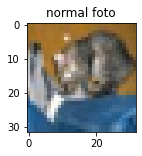

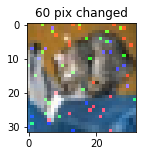

In [88]:
changed_photos_60 = perturbation_in_images(test_features, 60)
plt.figure(figsize= (2,2))
plt.title("normal foto")
plt.imshow(test_features[0])
plt.figure(figsize=(2,2))
plt.title("60 pix changed")
plt.imshow(changed_photos_60[0])


What? Ups I wrote it before I saw this photos and it turned out to be complete rubbish :D To be honest I don't really understand it why these photos are so different if I changed pixels by value 1. I thought that having range (0,256) changing value by 1 does not make any difference. Maybe my algorithm is incorrect? Unfortunately I have no time to explore it :(

Unfortunately I had no time to explore how my model would change if I made changes into model layers :(
